In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from keras.models import Sequential, Model
import keras
from keras import layers
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda,GlobalAveragePooling2D,Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import numpy as np
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

xscale = 192/640
yscale = 192/480
X_train = np.load('../Train_Processed_192.npy')
Y_train = np.load('../Y_train.npy')
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
print(X_train.shape)
print(Y_train.shape)
Y_train_new = []
for i in range(0,Y_train.shape[0]):
    Y_train_new.append(Y_train[i][0])
Y_train_new = np.asarray(Y_train_new)
print(Y_train_new.shape)
print(Y_train_new.shape[0])
for i in range(0,Y_train_new.shape[0]):
    Y_train_new[i][0] = Y_train_new[i][0] * xscale
    Y_train_new[i][1] = Y_train_new[i][1] * xscale
    Y_train_new[i][2] = Y_train_new[i][2] * yscale
    Y_train_new[i][3] = Y_train_new[i][3] * yscale
X_train = X_train/255
mean = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
print("Before ",mean.shape,std.shape)
X_train = X_train - mean
X_train = X_train / std
print("After ",X_train.mean(),X_train.std())

Using TensorFlow backend.


(14000, 192, 192, 1)
(14000, 1, 4)
(14000, 4)
14000


MemoryError: 

In [4]:
input_1 = Input(shape = (192,192,1))
# Block 1
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(input_1)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)

x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

x = layers.Dropout(0.2)(x)

# Block 3
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)

x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
# x = layers.Conv2D(256, (3, 3),
#                   activation='relu',
#                   padding='same',
#                   name='block3_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
x = layers.Dropout(0.2)(x)

# Block 4
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)

x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
# x = layers.Conv2D(512, (3, 3),
#                   activation='relu',
#                   padding='same',
#                   name='block4_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
x = layers.Dropout(0.2)(x)
# Block 5
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)

x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
# x = layers.Conv2D(512, (3, 3),
#                   activation='relu',
#                   padding='same',
#                   name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4,kernel_initializer='normal')(x)
model = Model(inputs=input_1, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()
rms = optimizers.RMSprop(lr=0.0001, rho=0.9)
adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adm,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 192, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0         
__________

In [7]:
#estimator = KerasRegressor(build_fn=model, epochs=10, batch_size=5, verbose=0)
#estimator.fit(X_train,Y_train_new)
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True,period=1)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3,verbose=1, mode='auto',restore_best_weights=True)
callbacks_list = [earlystop,checkpoint]
history=model.fit(X_train,Y_train_new, validation_split = 0.2 , batch_size = 8, callbacks = callbacks_list,epochs =25,verbose = 1)

Train on 11200 samples, validate on 2800 samples
Epoch 1/25
11200/11200 [==============================] - 324s 29ms/step - loss: 631.6460 - acc: 0.5157 - val_loss: 624.6634 - val_acc: 0.5357

Epoch 00001: val_loss improved from inf to 624.66335, saving model to weights-improvement-01-0.54.h5
Epoch 2/25
11200/11200 [==============================] - 322s 29ms/step - loss: 510.6868 - acc: 0.5105 - val_loss: 528.7517 - val_acc: 0.4643

Epoch 00002: val_loss improved from 624.66335 to 528.75171, saving model to weights-improvement-02-0.46.h5
Epoch 3/25
11200/11200 [==============================] - 321s 29ms/step - loss: 495.9025 - acc: 0.5049 - val_loss: 513.3458 - val_acc: 0.5393

Epoch 00003: val_loss improved from 528.75171 to 513.34584, saving model to weights-improvement-03-0.54.h5
Epoch 4/25
11200/11200 [==============================] - 321s 29ms/step - loss: 479.7415 - acc: 0.5157 - val_loss: 492.6468 - val_acc: 0.5357

Epoch 00004: val_loss improved from 513.34584 to 492.64685, 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


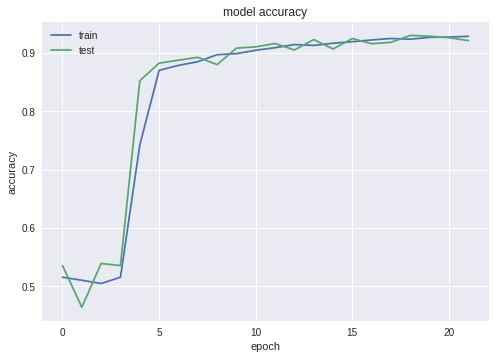

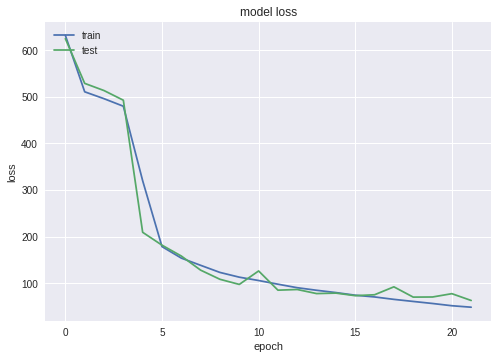

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'Model10_weights-improvement-05-0.85.h5'})
uploaded.SetContentFile('weights-improvement-05-0.85.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'Model10_weights-improvement-06-0.88.h5'})
uploaded.SetContentFile('weights-improvement-06-0.88.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'Model10_weights-improvement-12-0.92.h5'})
uploaded.SetContentFile('weights-improvement-12-0.92.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'Model10_weights-improvement-14-0.92.h5'})
uploaded.SetContentFile('weights-improvement-14-0.92.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'Model10_weights-improvement-16-0.93.h5'})
uploaded.SetContentFile('weights-improvement-16-0.93.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'Model10_weights-improvement-19-0.93.h5'})
uploaded.SetContentFile('weights-improvement-19-0.93.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'Model10_weights-improvement-22-0.92.h5'})
uploaded.SetContentFile('weights-improvement-22-0.92.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))



    100% |████████████████████████████████| 993kB 14.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
Uploaded file with ID 1LIN3XDkYRgRqZcjpigzOTEe4uw0h_YDw
Uploaded file with ID 1eENrgktDIBvbDAcx4QPUFxCIhvz8xApf
Uploaded file with ID 1RjP3lmKsLxGPMSljCTzwybJ52D7ux2aT
Uploaded file with ID 1MpIdZKLqjt8woBUQDLLlV-lprWOYYcxx
Uploaded file with ID 1TGWNLNzTUrjEwm_7lcSZMvJ_ZBD7ciW4
Uploaded file with ID 1oOyR46O4a52yLXcMMs-BAh5xsnwcKo3K
Uploaded file with ID 1e6Ceb9rrA5pbBYN3qylS1Wj1KwOOurCi


In [13]:
model.save_weights('Best_Model10.h5')
uploaded = drive.CreateFile({'title': 'Model10_best_weights.h5'})
uploaded.SetContentFile('Best_Model10.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1Gvk8_7ytOF6DUoHLJmgTl4T18l4x_u4r


In [0]:
X_test = np.load('/content/drive/My Drive/Updated_Data/Test_Processed_192.npy')
X_test = X_test/255
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_test = X_test - mean
X_test = X_test / std
print(X_test.shape)
#X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
model.save_weights('model9_weights.h5')

In [0]:
Y_predicted = model.predict(X_test)

In [0]:
print(Y_predicted.shape)
for i in range(0,Y_predicted.shape[0]):
    Y_predicted[i][0] = Y_predicted[i][0] / xscale
    Y_predicted[i][1] = Y_predicted[i][1] / xscale
    Y_predicted[i][2] = Y_predicted[i][2] / yscale
    Y_predicted[i][3] = Y_predicted[i][3] / yscale

(12815, 4)


In [0]:
X_label = np.load('/content/drive/My Drive/Updated_Data/X_test.npy')
X_label = X_label.reshape(X_label.shape[0],1)
print(X_label.shape)
for i in range(0,X_label.shape[0]):
  X_label[i] = X_label[i][0].split('/')[2]

print(X_label.shape)
print(X_label)
DF = np.concatenate((X_label, Y_predicted), axis=1)
print(DF.shape)
print(DF)
type(DF[0][2])

(12815, 1)
(12815, 1)
[['JPEG_20161129_130901_1000335000914.png']
 ['JPEG_20161209_201456_100034997460.png']
 ['14751585951781.png']
 ...
 ['JPEG_20160630_165248_1000513257867.png']
 ['1467548589518Odomos-Oil-Pack.png']
 ['1480334022239_R2A3610.png']]
(12815, 5)
[['JPEG_20161129_130901_1000335000914.png' '87.610634' '600.2036'
  '116.61931' '365.81793']
 ['JPEG_20161209_201456_100034997460.png' '165.46233' '453.78146'
  '96.82457' '349.06177']
 ['14751585951781.png' '158.67795' '542.9264' '66.22692' '396.4009']
 ...
 ['JPEG_20160630_165248_1000513257867.png' '226.13455' '423.87296'
  '98.36438' '323.1986']
 ['1467548589518Odomos-Oil-Pack.png' '50.45762' '605.2845' '22.133202'
  '444.2672']
 ['1480334022239_R2A3610.png' '137.6822' '455.89648' '51.407803'
  '317.8304']]


numpy.str_

In [0]:
import pandas as pd
out = pd.DataFrame({'image_name':DF[:,0],'x1':DF[:,1],'x2':DF[:,2],'y1':DF[:,3],'y2':DF[:,4]})

In [0]:
print(out.shape)
out.to_csv('new3.csv')

(12815, 5)


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'predictions_model8.csv'})
uploaded.SetContentFile('new3.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'new3_weights.h5'})
uploaded.SetContentFile('custom2_3_weights.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1d3MoVpamrgduxvpfFrAwfy_iG-K604_I
Uploaded file with ID 1YSTbjyOX0tCRY96lR82Aw9taC66JecIH


In [0]:
!ls


adc.json  custom2_2_weights.h5	drive  predictions.csv	sample_data


Uploaded file with ID 1WASMezxve0OfczQQ_mu9E64Pa7EdzsBq
